## MultiChanel- Deep Convolutional Neural Network (MC-DCNN):

### Let's try the 2 stage MC-DCNN (http://staff.ustc.edu.cn/~cheneh/paper_pdf/2014/Yi-Zheng-WAIM2014.pdf) architecture.  
#### Here features are first learned idependently on each channel with a cascade of 1D convolutions and maxpooling, then the learned features are concatenated and fed into a MLP. The MLP is in charge of learning the correlations between channels and classification.

In [2]:
import csv
import time
import numpy as np
import pandas as pd

from glob import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cross_validation import train_test_split
from scipy.signal import butter, lfilter, freqz, spectrogram
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
pd.options.mode.chained_assignment = None
from random import random
# import scipy

from sklearn.metrics import roc_auc_score
from numpy import fft
from numpy.random import randint
# Lasagne (& friends) imports
import theano
import theano.tensor as T

from nolearn.lasagne import BatchIterator, NeuralNet
from lasagne.objectives import aggregate, binary_crossentropy
import lasagne
from lasagne.layers import InputLayer,InverseLayer, DropoutLayer, DenseLayer,Conv1DLayer,MaxPool1DLayer,\
Upscale1DLayer, ReshapeLayer
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import sigmoid
import gc
from tqdm import tqdm
from IPython import display
import pylab as pl
from tqdm import tqdm

# Silence some warnings from lasagne
import warnings
warnings.filterwarnings('ignore', '.*topo.*')
warnings.filterwarnings('ignore', module='.*lasagne.init.*')
warnings.filterwarnings('ignore', module='.*nolearn.lasagne.*')


/Users/louis/Documents/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
#############Data loading and processing pipeline###########
# A couple of classes let us deal with parameters, and preprocessing of biometrig data (ppg + accelerometer)
# we do some preprocessing, incuding replacing missing values,
#turning date/hour into floats, scaling, and low pass filter
# The time series are sliced into windows of length FREQ_WINDOW
class Param(object):
    
    def __init__(self):
        
        self.N_USERS = 10
        self.N_CHANNELS = 22
        self.TEST_TRAIN_SPLIT = 0.80 # fraction of data for train/test
        # low pass filter requirements.
        self.ORDER = 1
        self.FS = 1.0 # approx sample rate, Hz
        self.CUTOFF = 0.00046# desired cutoff frequency,Hz(~30 minute periods)
        self.SUBSAMPLE = 40
        # spectrogram requirement:
        self.FREQ_WINDOW = 800 # size of the sliding window
        self.STEP = self.FREQ_WINDOW-400
        
        
class BioDataset(object):
    
    def __init__(self,filename,Param):
        
        self.filename = filename
        self.p = Param # pass data and preprossing parameters
        self.scaler_1 = None # initialize pre-pross feature scaler
        self.scaler_2 = None # initialize post-pross feature scaler
    
    def butter_lowpass(self):
        """ construct butter low pass filter """
        nyq = 0.5 * self.p.FS
        normal_cutoff = self.p.CUTOFF / nyq
        b, a = butter(self.p.ORDER, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(self,data):
        """ apply butter low pass filter to data """
        b, a = self.butter_lowpass()
        y = lfilter(b, a, data)
        return y

    def load_data(self):
        """ load and clean data """
        # Read data
        X = pd.read_csv(self.filename,parse_dates = ['_datetime','_calendar_date'])
        # Clean up missing values 
        X = X.dropna(axis ='index', thresh=0)
        X = X.fillna(axis = 'index',method = 'bfill')
        X = X.fillna(axis = 'index',method = 'ffill')

        return  X

    def split_train_test(self,X):
        """ split data into train/test group chronologically """
        # reasign parameters locally for readibility
        N_USERS = self.p.N_USERS
        TEST_TRAIN_SPLIT = self.p.TEST_TRAIN_SPLIT
        FREQ_WINDOW = self.p.FREQ_WINDOW
        
        X_sort = X.sort_values(by=['_datetime'])
        X_sort['_calendar_date'] = pd.DatetimeIndex(X_sort['_calendar_date']).weekday
        X_sort['_datetime'] = pd.DatetimeIndex(X_sort['_datetime']).hour
    
        X_train = []
        X_test = []
        for n in range(N_USERS):
            # split data into 75-25% train/test, chronologically, for each user
            X_user = X_sort[X_sort['_user_id']==n]
            split_indice = int(np.floor(X_user.shape[0]*TEST_TRAIN_SPLIT))
            X_train += [X_user[:split_indice]]
            X_test += [X_user[split_indice:]]
            
        X_train = pd.concat(X_train)
        X_train.drop('_cap_seq', axis=1, inplace=True)

        X_test = pd.concat(X_test)
        X_test.drop('_cap_seq', axis=1, inplace=True)
        
        return X_train,X_test

    def preprocess_data(self,X):
        """ preprocess (scaling + low pass filter + spectrogram) training data """
        # reasign parameters locally for readibility
        N_USERS = self.p.N_USERS
        TEST_TRAIN_SPLIT = self.p.TEST_TRAIN_SPLIT
        FREQ_WINDOW = self.p.FREQ_WINDOW
        N_CHANNELS = self.p.N_CHANNELS
        STEP = self.p.STEP
        
        # Separate data into users 
        X_user = [X[X['_user_id']==i] for i in range(N_USERS) if i != 8]

        # Remove user id information
        for n,us in enumerate(X_user):
            X_user[n].drop('_user_id', axis=1, inplace=True)

        # Construct a feature scaler (scaling of test data is done with mean and std from train data)
        if self.scaler_1 is None:
            self.scaler_1 = StandardScaler().fit(np.asarray(pd.concat(X_user)).astype(float))

        X_windowed = np.array([]).reshape((0,FREQ_WINDOW,N_CHANNELS+2))
        y_windowed = []
        X_n = []
        X_prepro = []
        X_prepro_scaled = []
        # Features extraction
        for n in range(N_USERS-1):
            # scale the features:
            X_prep_normal = self.scaler_1.transform((np.asarray(X_user[n])).astype(float))
            X_prep_low = np.zeros((np.shape(X_prep_normal)[0],N_CHANNELS))
            
            for col in range(N_CHANNELS):
                z0 = X_prep_normal[:,col+2][0]
                # apply a low pass filter:
                X_prep_low[:,col] = z0 + self.butter_lowpass_filter(X_prep_normal[:,col+2]-z0)
            
            X_prepro += [np.hstack([X_prep_normal[:,:2],X_prep_low])]
            
        if self.scaler_2 is None:
            self.scaler_2 = StandardScaler().fit(np.concatenate(X_prepro).astype(float))

        
        for n in range(N_USERS-1):
            print "preprocessing user %d..."%n
            X_prepro_scaled = self.scaler_2.transform(X_prepro[n])
            for k in range(0,X_prepro_scaled.shape[0]-FREQ_WINDOW,STEP):
               
                X_windowed = np.vstack([X_windowed,X_prepro_scaled[k:k+FREQ_WINDOW\
                                                                   ,...].reshape((1,FREQ_WINDOW,N_CHANNELS+2))])
                
                y_windowed += [n]
            print "done"
                
        return np.swapaxes(X_windowed,1,2).astype("float32"), np.array([y_windowed]).astype("int32").reshape(-1)

    

In [4]:
parameters = Param()
ds = BioDataset('biodb.csv',parameters)
# load data:
X_raw = ds.load_data()
X_train_raw,X_test_raw = ds.split_train_test(X_raw)

X_train,y_train_total = ds.preprocess_data(X_train_raw)
y_train = label_binarize(y_train_total,classes=range(parameters.N_USERS-1)).astype("int32")
# Prepocess test data (here the scaling is done using mean and std from training data):
X_test,y_test_total = ds.preprocess_data(X_test_raw)
y_test = label_binarize(y_test_total,classes=range(parameters.N_USERS-1)).astype("int32")

print X_train.shape, X_test.shape
print X_train.mean(), X_train.std()
print X_test.mean(), X_test.std()

preprocessing user 0...
done
preprocessing user 1...
done
preprocessing user 2...
done
preprocessing user 3...
done
preprocessing user 4...
done
preprocessing user 5...
done
preprocessing user 6...
done
preprocessing user 7...
done
preprocessing user 8...
done
preprocessing user 0...
done
preprocessing user 1...
done
preprocessing user 2...
done
preprocessing user 3...
done
preprocessing user 4...
done
preprocessing user 5...
done
preprocessing user 6...
done
preprocessing user 7...
done
preprocessing user 8...
done
(420, 24, 800) (95, 24, 800)
-0.000799445 0.986007
0.00186059 1.01973


In [4]:
from batchNormalization import BatchNormLayer

def batch_norm(layer, **kwargs):
    nonlinearity = getattr(layer, 'nonlinearity', None)
    if nonlinearity is not None:
        layer.nonlinearity = lasagne.nonlinearities.identity
    if hasattr(layer, 'b') and layer.b is not None:
        del layer.params[layer.b]
        layer.b = None
    layer = BatchNormLayer(layer, **kwargs)
    if nonlinearity is not None:
        from lasagne.layers import NonlinearityLayer
        layer = NonlinearityLayer(layer, nonlinearity)
    return layer

In [5]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def iterator(X, batchsize):
    indices = np.arange(len(X))
    for i in range(0, len(X) - batchsize + 1, batchsize):
        sli = indices[i:i+batchsize]
        yield X[sli]

def save_params(model, fn):
    with open(fn, 'w') as wr:
        pickle.dump(lasagne.layers.get_all_param_values(model), wr)

### MC DCNN:

In [11]:
batch_size = None

def build_MC_DCNN(input_var = [None]*(parameters.N_CHANNELS+2)):
    
    conv_num_filters1 = 4
    conv_num_filters2 = 4
    filter_size1 = 5
    filter_size2 = 5
    pool_size = 4
    pad_in = 'valid'
    pad_out = 'full'
    dense_units = 32
    ########################
    # Here we build a dictionnary to construct independent layers for each channel:
    network = {} 
    for i in range(parameters.N_CHANNELS+2):
        
        network[i] = InputLayer(shape=(batch_size,1,parameters.FREQ_WINDOW),input_var=input_var[i],name="input_layer_1")  
        
        network[i] = batch_norm(Conv1DLayer(
                network[i], num_filters=conv_num_filters1, filter_size=filter_size1,
                nonlinearity=lasagne.nonlinearities.tanh,
                W=lasagne.init.GlorotUniform(),pad = pad_in,name="conv1_1"))

        network[i] = MaxPool1DLayer(network[i], pool_size=pool_size,name="pool1_1")

        network[i] = batch_norm(Conv1DLayer(
                network[i], num_filters=conv_num_filters2, filter_size=filter_size2,
                nonlinearity=lasagne.nonlinearities.tanh,
                W=lasagne.init.GlorotUniform(),pad = pad_in,name="conv2_1"))

        network[i] = MaxPool1DLayer(network[i], pool_size=pool_size,name="pool2_1")

        network[i] = ReshapeLayer(network[i], shape = ([0],-1), name = "reshape_1")
        
    
    #######################
    # Now we concatenate the output from each channel layer, and build a MLP:
    
    network2 = lasagne.layers.ConcatLayer(network.values(),axis = 1, name = "concat")
    
    
    network2 = batch_norm(lasagne.layers.DenseLayer(network2, num_units=dense_units, \
                                  W = lasagne.init.GlorotUniform(),name = "dense1"))
    
    network2 = batch_norm(lasagne.layers.DenseLayer(network2, num_units=parameters.N_USERS-1, \
                                  W = lasagne.init.GlorotUniform(), \
                                  nonlinearity=lasagne.nonlinearities.softmax,name = "output"))
    
    return network2



In [14]:
## The target values (correct classes) are stored a one hot matrix, of size Training_samples x classes
target_values = T.imatrix('target_output')

# we then build a dictionary of input variables (one per channel)
inps = {}
for i in range(parameters.N_CHANNELS+2):
    inps[i] = T.tensor3()

# Let's build the MC_DCNN, and check the architecture by printing out the layer sizes and names:
network = build_MC_DCNN(inps.values())

laylist = lasagne.layers.get_all_layers(network)
    
for l in laylist:
    print(l.name, lasagne.layers.get_output_shape(l))

num_params = lasagne.layers.count_params(network)

print("number of parameters is {}".format(num_params))

# lasagne.layers.get_output produces an expression for the output of the net:
network_output = lasagne.layers.get_output(network)

# Our cost will be categorical cross-entropie
cost = lasagne.objectives.categorical_crossentropy(network_output, target_values)
cost = cost.mean()

# Retrieve all parameters from the network
all_params = lasagne.layers.get_all_params(network ,trainable = True)
# Compute adam updates for training
updates = lasagne.updates.adam(cost, all_params)
# Theano functions for training and computing cost. 
train = theano.function(inps.values()+[target_values],cost, updates=updates)
compute_cost = theano.function(inps.values()+[target_values], cost)

# Theano functions for forward pass:
predicted_values = lasagne.layers.get_output(network, deterministic=True)
predict = theano.function(inps.values(),[predicted_values])

('input_layer_1', (None, 1, 800))
('conv1_1', (None, 4, 796))
(None, (None, 4, 796))
(None, (None, 4, 796))
('pool1_1', (None, 4, 199))
('conv2_1', (None, 4, 195))
(None, (None, 4, 195))
(None, (None, 4, 195))
('pool2_1', (None, 4, 48))
('reshape_1', (None, 192))
('input_layer_1', (None, 1, 800))
('conv1_1', (None, 4, 796))
(None, (None, 4, 796))
(None, (None, 4, 796))
('pool1_1', (None, 4, 199))
('conv2_1', (None, 4, 195))
(None, (None, 4, 195))
(None, (None, 4, 195))
('pool2_1', (None, 4, 48))
('reshape_1', (None, 192))
('input_layer_1', (None, 1, 800))
('conv1_1', (None, 4, 796))
(None, (None, 4, 796))
(None, (None, 4, 796))
('pool1_1', (None, 4, 199))
('conv2_1', (None, 4, 195))
(None, (None, 4, 195))
(None, (None, 4, 195))
('pool2_1', (None, 4, 48))
('reshape_1', (None, 192))
('input_layer_1', (None, 1, 800))
('conv1_1', (None, 4, 796))
(None, (None, 4, 796))
(None, (None, 4, 796))
('pool1_1', (None, 4, 199))
('conv2_1', (None, 4, 195))
(None, (None, 4, 195))
(None, (None, 4, 195)

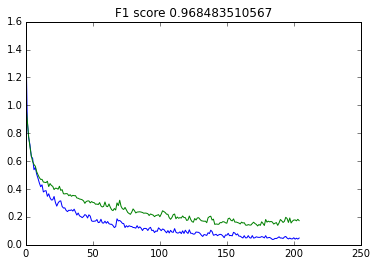

 51%|█████▏    | 205/400 [16:03<14:49,  4.56s/it]


KeyboardInterrupt: 

In [15]:
# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs: 
num_epochs = 400
error_train = []
error_val = []
for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    batch_siz = 42
    for batch in iterate_minibatches(X_train, y_train, batch_siz, shuffle=True):
        inputs, targets = batch
        #Here we splits the input into individual channels:
        inputs2 = [inputs[:,i,:].reshape(-1,1,parameters.FREQ_WINDOW) for i in range(parameters.N_CHANNELS+2)]
        argList = inputs2+[targets]
        
        train_err += train(*argList)
        train_batches += 1
        
    #And a full pass over the validation data:
    val_err = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 95, shuffle=False):
        inputs, targets = batch
        inputs2 = [inputs[:,i,:].reshape(-1,1,parameters.FREQ_WINDOW) for i in range(parameters.N_CHANNELS+2)]
        argList = inputs2+[targets]
        
        val_err += compute_cost(*argList)
        val_batches += 1

    error_train += [train_err / train_batches]
    error_val += [val_err / val_batches]
    
    
    # Each epoch, we do some predictions on the test data and compute the F1 score:
    inputs_pred = [X_test[:,i,:].reshape(-1,1,parameters.FREQ_WINDOW) for i in range(parameters.N_CHANNELS+2)]
    
    y_pred = [y.argmax() for y in predict(*inputs_pred)[0]]
    y_true = [y.argmax() for y in y_test]

    # Let's plot the training/testing error
    pl.plot(error_train)
    pl.plot(error_val)
    pl.title("F1 score {}".format(f1_score(y_true, y_pred)))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    pl.close()